## Installation and importing of library

Image size = 224
batch size = 64

In [ ]:
!pip install vit_keras
!pip install colorama

## Dowloading the dataset from Kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("saikumar1619/tensorcraft25-dataset-clip")

print("Path to dataset files:", path)

100%|██████████| 119M/119M [00:00<00:00, 135MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1


In [ ]:
!pip install --upgrade tensorflow keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 36.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
from colorama import Fore, Back, Style
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dropout, Flatten, Dense, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 10
AUTO = tf.data.AUTOTUNE

### Seprating the train,test and valid datasets

In [ ]:
image_path = '/root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1/'

train_data = pd.read_csv("/root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1/train.csv")
train_data['filepath'] = image_path + train_data['filepath']

valid_data = pd.read_csv("/root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1/valid.csv")
valid_data['filepath'] = image_path + valid_data['filepath']

test_data = pd.read_csv("/root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1/test.csv")
test_data['filepath'] = image_path + test_data['filepath']

## Text tokenization and preprocessing

In [ ]:
def text_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("["," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("''"," "))
    data['captions'] = data['captions'].apply(lambda x: x.lower())
    data['captions'] = data['captions'].apply(lambda x: x.replace("[^A-Za-z]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("\s+"," "))
    data['captions'] = data['captions'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    return data

def splitting_captions(df):
    captions_arr = []
    filepaths_arr = []

    for i in range(df.shape[0]):
        img = df['filepath'].values[i]
        captions = re.split(r"' '", df['captions'].values[i])
        for caption in captions:
            captions_arr.append(caption)
            filepaths_arr.append(img)

    data = pd.DataFrame({'captions': captions_arr, 'filepath': filepaths_arr})

    return data

def last_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("'",""))
    data['captions'] = data['captions'].apply(lambda x: x.replace(".",""))
    data['captions'] = "startseq "+data['captions']+" endseq"

    return data

In [ ]:
train_data_preprocessed = text_preprocessing(train_data)
train_data_preprocessed = splitting_captions(train_data_preprocessed)
train_data_new = last_preprocessing(train_data_preprocessed)

valid_data_preprocessed = text_preprocessing(valid_data)
valid_data_preprocessed = splitting_captions(valid_data_preprocessed)
valid_data_new = last_preprocessing(valid_data_preprocessed)

test_data_preprocessed = text_preprocessing(test_data)
test_data_preprocessed = splitting_captions(test_data_preprocessed)
test_data_new = last_preprocessing(test_data_preprocessed)


print('train shape -> ', train_data_new.shape[0])
print('valid shape -> ', valid_data_new.shape[0])
print('test shape -> ', test_data_new.shape[0])

train shape ->  41206
valid shape ->  5147
test shape ->  5203


In [ ]:
train_data_new.iloc[SEED].captions

'startseq many aircraft are parked in an airport near many runways endseq'

In [ ]:
captions = train_data_new['captions'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_images = train_data_new['filepath'].unique().tolist()
train = train_data_preprocessed[train_data_preprocessed['filepath'].isin(train_images)]
train.reset_index(inplace=True,drop=True)

valid_images = valid_data_new['filepath'].unique().tolist()
valid = valid_data_preprocessed[valid_data_preprocessed['filepath'].isin(valid_images)]
valid.reset_index(inplace=True,drop=True)

test_images = test_data_new['filepath'].unique().tolist()
test = test_data_preprocessed[test_data_preprocessed['filepath'].isin(test_images)]
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[SEED]])[0]

[1, 5, 189, 3, 48, 10, 26, 55, 16, 5, 234, 2]

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

IMG_SIZE = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

vit_model = hub.load("https://tfhub.dev/sayakpaul/vit_b16_fe/1")

def extract_features(images):
    return vit_model(images)


### Feature Extractor of ViT

In [ ]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
features = tf.keras.layers.Lambda(extract_features)(inputs)
feature_extractor = tf.keras.Model(inputs, features)

feature_extractor.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 768)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Image processing

In [ ]:
def img_preprocessing(img, caption):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, 9999

In [ ]:
train_loader_for_img_features = tf.data.Dataset.from_tensor_slices((train['filepath'], train['captions']))
train_dataset_for_img_features = (train_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


valid_loader_for_img_features = tf.data.Dataset.from_tensor_slices((valid['filepath'], valid['captions']))
valid_dataset_for_img_features = (valid_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


test_loader_for_img_features = tf.data.Dataset.from_tensor_slices((test['filepath'], test['captions']))
test_dataset_for_img_features = (test_loader_for_img_features
                                 .map(img_preprocessing, num_parallel_calls = AUTO)
                                 .batch(BATCH_SIZE)
                                 .prefetch(AUTO))

In [ ]:
def create_img_feature_dict(feature_extractor_model, tf_dataset, df):
    img_features = feature_extractor_model.predict(tf_dataset)
    features_dict = {}

    assert df.shape[0] == img_features.shape[0]
    for i in range(df.shape[0]):
        img_feature = tf.expand_dims(img_features[i], axis=0)
        features_dict[df['filepath'].iloc[i]] = img_feature

    return features_dict

In [ ]:
train_img_features = create_img_feature_dict(feature_extractor, train_dataset_for_img_features, train)
valid_img_features = create_img_feature_dict(feature_extractor, valid_dataset_for_img_features, valid)
test_img_features = create_img_feature_dict(feature_extractor, test_dataset_for_img_features, test)

1288/1288 ━━━━━━━━━━━━━━━━━━━━ 509s 391ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 68s 424ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 418ms/step


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True, **kwargs):
        super(CustomDataGenerator, self).__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch['filepath'].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch['filepath']== image, 'captions'].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)


        return X1, X2, y

In [ ]:
train_generator = CustomDataGenerator(df = train_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer,vocab_size = vocab_size,
                                      max_length = max_length, features = train_img_features)

valid_generator = CustomDataGenerator(df = valid_data_new,batch_size = BATCH_SIZE, tokenizer=tokenizer,vocab_size=vocab_size,
                                      max_length = max_length, features = valid_img_features, shuffle = False)


test_generator = CustomDataGenerator(df = test_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer, vocab_size=vocab_size,
                                     max_length = max_length, features = test_img_features, shuffle = False)

## Model layer that is made to connect image and the text

In [ ]:
input1 = Input(shape=(768,))
input2 = Input(shape=(max_length,))

img_features = Dense(512, activation='relu')(input1)
img_features_reshaped = Reshape((1, 512), input_shape=(512,))(img_features)

sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = Bidirectional(LSTM(256, dropout=0.1))(merged)

X = Dropout(0.5)(sentence_features)
X = add([X, img_features])
X = Dense(128, activation='relu')(X)
X = Dropout(0.5)(X)
output = Dense(vocab_size, activation='softmax')(X)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',
                          optimizer=tf.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004))

caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        393,728 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 53)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 512)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 512)        │      1,381,376 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 54, 512)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512)            │      1,574,912 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         65,664 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2698)           │        348,042 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,763,722 (14.36 MB)

 Trainable params: 3,763,722 (14.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
caption_model.input_shape

[(None, 768), (None, 53)]

### Training loop

In [ ]:
hist = caption_model.fit(train_generator,epochs = 10, validation_data = valid_generator, callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, restore_best_weights = True)])

Epoch 1/10
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 159s 119ms/step - loss: 3.4529 - val_loss: 2.2719
Epoch 2/10
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 135s 105ms/step - loss: 2.0743 - val_loss: 2.1996
Epoch 3/10
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 135s 105ms/step - loss: 1.9057 - val_loss: 2.1789
Epoch 4/10
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 135s 105ms/step - loss: 1.7994 - val_loss: 2.2054
Epoch 5/10
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 135s 104ms/step - loss: 1.7295 - val_loss: 2.1991


In [ ]:
test_eval = caption_model.evaluate(test_generator)

162/162 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - loss: 3.1545


## Sample Predictions of the model

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred_ = model.predict([feature,sequence], verbose = 0)
        y_pred = np.argmax(y_pred_)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word
        if word == 'endseq':
            break

    return in_text, y_pred_, y_pred

In [ ]:
samples = test.sample(50)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():
    image_path = image_path + '/'

    img = load_img(os.path.join(image_path,record['filepath']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['filepath'], tokenizer, max_length, test_img_features)
    samples.loc[index,'captions'] = caption

In [ ]:

def display_prediction_images(temp_df, SEED):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (5,5))

    idx = np.random.default_rng(seed=SEED).permutation(temp_df.shape[0])[0]
    img = cv2.imread(temp_df.iloc[idx]['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_captions = test.loc[test['filepath']== temp_df.filepath[idx], 'captions'].tolist()[:3]

    pred_caption = temp_df.iloc[idx]['captions'][0]
    pred_caption = pred_caption.replace('startseq ', ' ')
    pred_caption = pred_caption.replace(' endseq', ' ')


    for true_caption in true_captions:
        true_caption = true_caption.replace('startseq ', ' ')
        true_caption = true_caption.replace(' endseq', ' ')
        print(Fore.GREEN + "TRUE : " +true_caption + '\n')


    print(Fore.RED + "PRED : "+ pred_caption)


    plt.imshow(img)
    plt.axis('off')

TRUE :  the parking lot is close to the pool next to building in the shape of woth red roof on the beach 

TRUE :  the parking lot is close to the swimming pool next to red roof shaped building on the beach  

TRUE :  the parking lot is close to the swimming pool next to shaped building woth red roof on the beach  

PRED :  many green trees and some buildings are in resort 


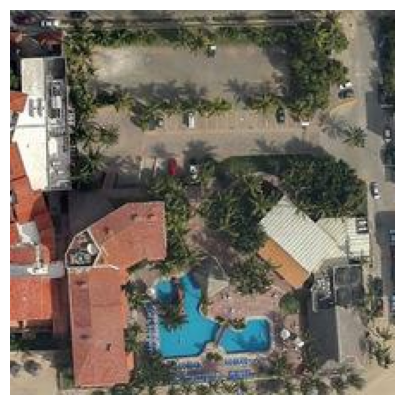

In [ ]:
display_prediction_images(samples, 89)

TRUE :  there is road across the open khaki desert  

TRUE :  some clumps of grey mass are lying on the orange desert  

TRUE :  a rock separates the orange desert  

PRED :  many undulations are in piece of yellow desert 


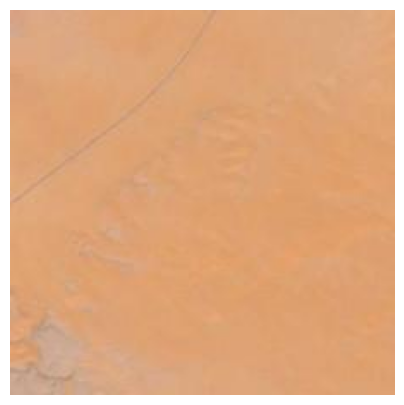

In [ ]:
display_prediction_images(samples, 30)

## Evaluation Metrics
```
BLEU1: 88.45%
BLEU2: 80.85%
BLEU3: 73.45%
BLEU4: 67.21%
ROUGE1: 50.35%
ROUGE2: 25.96%
ROUGEL: 45.34%
```

Similarity Metrics:
========================================
```
Cosine Similarity: 18.52%
CIDEr Score: 0.69 / 10.0
```

In [ ]:
!pip install nltk rouge-score datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=08b7b86549c65b99fa0b0b78a2dac9109dbf9dac57b026d33895c503c4db480e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import os
import pandas as pd

base_url = "/root/.cache/kagglehub/datasets/saikumar1619/tensorcraft25-dataset-clip/versions/1/"

test_csv_path = os.path.join(base_url, "test.csv")
test_df = pd.read_csv(test_csv_path)

test_df['filepath'] = test_df['filepath'].apply(lambda x: os.path.join(base_url, x))

print(test_df.head())

                                            captions  \
0  ['The airport is very large.' 'next to the air...   
1  ['green grass on both sides of the runway.'\n ...   
2  ["There's a lot of bare ground around the airp...   
3  ["There's a lot of bare land near the airport....   
4  ['the airport covers a large area and has many...   

                                            filepath  
0  /root/.cache/kagglehub/datasets/saikumar1619/t...  
1  /root/.cache/kagglehub/datasets/saikumar1619/t...  
2  /root/.cache/kagglehub/datasets/saikumar1619/t...  
3  /root/.cache/kagglehub/datasets/saikumar1619/t...  
4  /root/.cache/kagglehub/datasets/saikumar1619/t...  


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0
    return img

def tokenize_caption(caption, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([caption])[0]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    return sequence

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge_score import rouge_scorer
import numpy as np

def evaluate_captions(true_captions, predicted_captions):
    """
    Evaluate caption predictions using multiple metrics

    Parameters:
    true_captions: List of lists of reference captions for each image
    predicted_captions: List of predicted captions (can be tuples from predict_caption function)

    Returns:
    Dictionary containing different evaluation metrics
    """
    cleaned_preds = [cap[0].replace('startseq ', '').replace(' endseq', '').strip()
                    if isinstance(cap, tuple) else cap.replace('startseq ', '').replace(' endseq', '').strip()
                    for cap in predicted_captions]

    cleaned_refs = [[cap.replace('startseq ', '').replace(' endseq', '').strip()
                     for cap in refs] for refs in true_captions]

    bleu1 = corpus_bleu(cleaned_refs, cleaned_preds, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(cleaned_refs, cleaned_preds, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(cleaned_refs, cleaned_preds, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(cleaned_refs, cleaned_preds, weights=(0.25, 0.25, 0.25, 0.25))

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []

    for pred, refs in zip(cleaned_preds, cleaned_refs):
        scores = [scorer.score(pred, ref) for ref in refs]
        max_scores = {
            'rouge1': max(score['rouge1'].fmeasure for score in scores),
            'rouge2': max(score['rouge2'].fmeasure for score in scores),
            'rougeL': max(score['rougeL'].fmeasure for score in scores)
        }
        rouge_scores.append(max_scores)

    avg_rouge = {
        'rouge1': np.mean([s['rouge1'] for s in rouge_scores]),
        'rouge2': np.mean([s['rouge2'] for s in rouge_scores]),
        'rougeL': np.mean([s['rougeL'] for s in rouge_scores])
    }

    metrics = {
        'bleu1': bleu1 * 100,
        'bleu2': bleu2 * 100,
        'bleu3': bleu3 * 100,
        'bleu4': bleu4 * 100,
        'rouge1': avg_rouge['rouge1'] * 100,
        'rouge2': avg_rouge['rouge2'] * 100,
        'rougeL': avg_rouge['rougeL'] * 100
    }

    return metrics

def prepare_evaluation_data(test_df, samples_df):
    """
    Prepare the true captions and predicted captions for evaluation
    """
    true_captions = []
    predicted_captions = []

    for idx, row in samples_df.iterrows():
        refs = test_df[test_df['filepath'] == row['filepath']]['captions'].tolist()
        true_captions.append(refs)
        predicted_captions.append(row['captions'])

    return true_captions, predicted_captions

true_caps, pred_caps = prepare_evaluation_data(test, samples)
metrics = evaluate_captions(true_caps, pred_caps)

for metric, value in metrics.items():
    print(f"{metric.upper():>10}: {value:.2f}%")

     BLEU1: 88.45%
     BLEU2: 80.85%
     BLEU3: 73.45%
     BLEU4: 67.21%
    ROUGE1: 50.35%
    ROUGE2: 25.96%
    ROUGEL: 45.34%


In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math

def compute_cider(candidate, references, n=4):
    """
    Compute CIDEr score between a candidate caption and its references
    """
    def get_ngrams(text, n):
        words = text.lower().split()
        ngrams = defaultdict(int)
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i+n])
            ngrams[ngram] += 1
        return ngrams

    doc_freq = defaultdict(float)
    for ref in references:
        ref_ngrams = get_ngrams(ref, n)
        for ngram in ref_ngrams:
            doc_freq[ngram] += 1

    num_refs = len(references)
    for ngram, freq in doc_freq.items():
        doc_freq[ngram] = math.log(num_refs / freq)

    cand_ngrams = get_ngrams(candidate, n)

    scores = []
    for ref in references:
        ref_ngrams = get_ngrams(ref, n)

        common_ngrams = set(cand_ngrams.keys()) & set(ref_ngrams.keys())

        vec1 = [cand_ngrams[ng] * doc_freq[ng] for ng in common_ngrams]
        vec2 = [ref_ngrams[ng] * doc_freq[ng] for ng in common_ngrams]

        if len(vec1) == 0:
            scores.append(0)
        else:
            magnitude1 = math.sqrt(sum(v * v for v in vec1))
            magnitude2 = math.sqrt(sum(v * v for v in vec2))
            if magnitude1 == 0 or magnitude2 == 0:
                scores.append(0)
            else:
                dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
                scores.append(dot_product / (magnitude1 * magnitude2))

    return np.mean(scores) * 10.0

def compute_metrics(true_captions, predicted_captions):
    """
    Compute cosine similarity and CIDEr scores for the captions
    """
    cleaned_preds = [cap[0].replace('startseq ', '').replace(' endseq', '').strip()
                    if isinstance(cap, tuple) else cap.replace('startseq ', '').replace(' endseq', '').strip()
                    for cap in predicted_captions]

    cleaned_refs = [[cap.replace('startseq ', '').replace(' endseq', '').strip()
                     for cap in refs] for refs in true_captions]

    cosine_scores = []
    cider_scores = []

    for pred, refs in zip(cleaned_preds, cleaned_refs):
        all_texts = [pred] + refs
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(all_texts)
        similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])
        cosine_scores.append(np.mean(similarities[0]))

        cider_score = compute_cider(pred, refs)
        cider_scores.append(cider_score)

    return {
        'cosine_similarity': np.mean(cosine_scores) * 100,
        'cider_score': np.mean(cider_scores)
    }


true_caps, pred_caps = prepare_evaluation_data(test, samples)
metrics = compute_metrics(true_caps, pred_caps)

print("\nSimilarity Metrics:")
print("=" * 40)
print(f"Cosine Similarity: {metrics['cosine_similarity']:.2f}%")
print(f"CIDEr Score: {metrics['cider_score']:.2f} / 10.0")


Similarity Metrics:
Cosine Similarity: 18.52%
CIDEr Score: 0.69 / 10.0


## Model Saved

In [ ]:
import shutil
import os

if os.path.exists("caption_model"):
    shutil.rmtree("caption_model")

caption_model.save("caption_model.keras")
print("model saved")

model saved
